In [1]:
import csv
import json
import pandas as pd

In [2]:
url2rank = {}
csv_file_path = f'../measurement_data/tranco_top-1m_20240411.csv'
with open(csv_file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        url_id, url = row[0], row[1]
        url2rank[url]=url_id

url2botinfo_path = f'../measurement_data/url2botinfo_20240411.json'
with open(url2botinfo_path, 'r') as f:
    url2botinfo = json.load(f)

In [3]:
# Exclude RAG bots as policy is only concerning LLM training
llm_bots = [
    'GPTBot', 'Google-Extended', 'anthropic-ai', 'cohere-ai', 
    "Amazonbot", "FacebookBot", "Bytespider", "Yeti", 
    "YandexBot", "Baiduspider", "PetalBot",
]
databroker_bots = [
    "CCBot", 
    "Omgilibot", 
]

target_bots = llm_bots + databroker_bots

In [4]:
df_matched = pd.read_excel('../measurement_data/policy_trainingAI_phrase_matching_domains_tagged.xlsx')
print(f"Number of unique domains before filtering: {len(set(df_matched['domain'].tolist()))}")
df_matched = df_matched[df_matched['tag']=='o']
print(f"Number of unique domains after filtering for tag 'o': {len(set(df_matched['domain'].tolist()))}")

df_news = pd.read_excel('../measurement_data/policy_trainingAI_news_websites_tagged.xlsx')
df_news = df_news[df_news['allowed'] == 'o']

# disallowed domains
domains = set(df_matched['domain'].tolist()).union(df_news['Website'].tolist())


Number of unique domains before filtering: 187
Number of unique domains after filtering for tag 'o': 98


In [5]:
bot2access_info = {}

for bot in target_bots:
    bot2access_info[bot] = {'allow_full': [], 'partial': [], 'disallow_full': []}
    for domain in domains:
        bot_info = url2botinfo[domain]
        if bot in bot_info:
            if bot_info[bot] == {'allow': [], 'disallow': ['/']}:
                bot2access_info[bot]['disallow_full'].append(domain)
            else:
                if bot_info[bot] == {'allow': [], 'disallow': []}:
                    bot2access_info[bot]['allow_full'].append(domain)
                else:
                    bot2access_info[bot]['partial'].append(domain)
                
        else:
            if '*' in bot_info:
                if bot_info['*'] == {'allow': [], 'disallow': ['/']}:
                    bot2access_info[bot]['disallow_full'].append(domain)
                else:
                    if bot_info['*'] == {'allow': [], 'disallow': []}:
                        bot2access_info[bot]['allow_full'].append(domain)
                    else:
                        bot2access_info[bot]['partial'].append(domain)

            else:
                bot2access_info[bot]['allow_full'].append(domain)


In [6]:
# Counting domains
bots = list(bot2access_info.keys())
allow_all = [len(bot2access_info[bot]['allow_full']) for bot in bots]
partial = [len(bot2access_info[bot]['partial']) for bot in bots]
disallow_all = [len(bot2access_info[bot]['disallow_full']) for bot in bots]


## Plot (Figure 7)

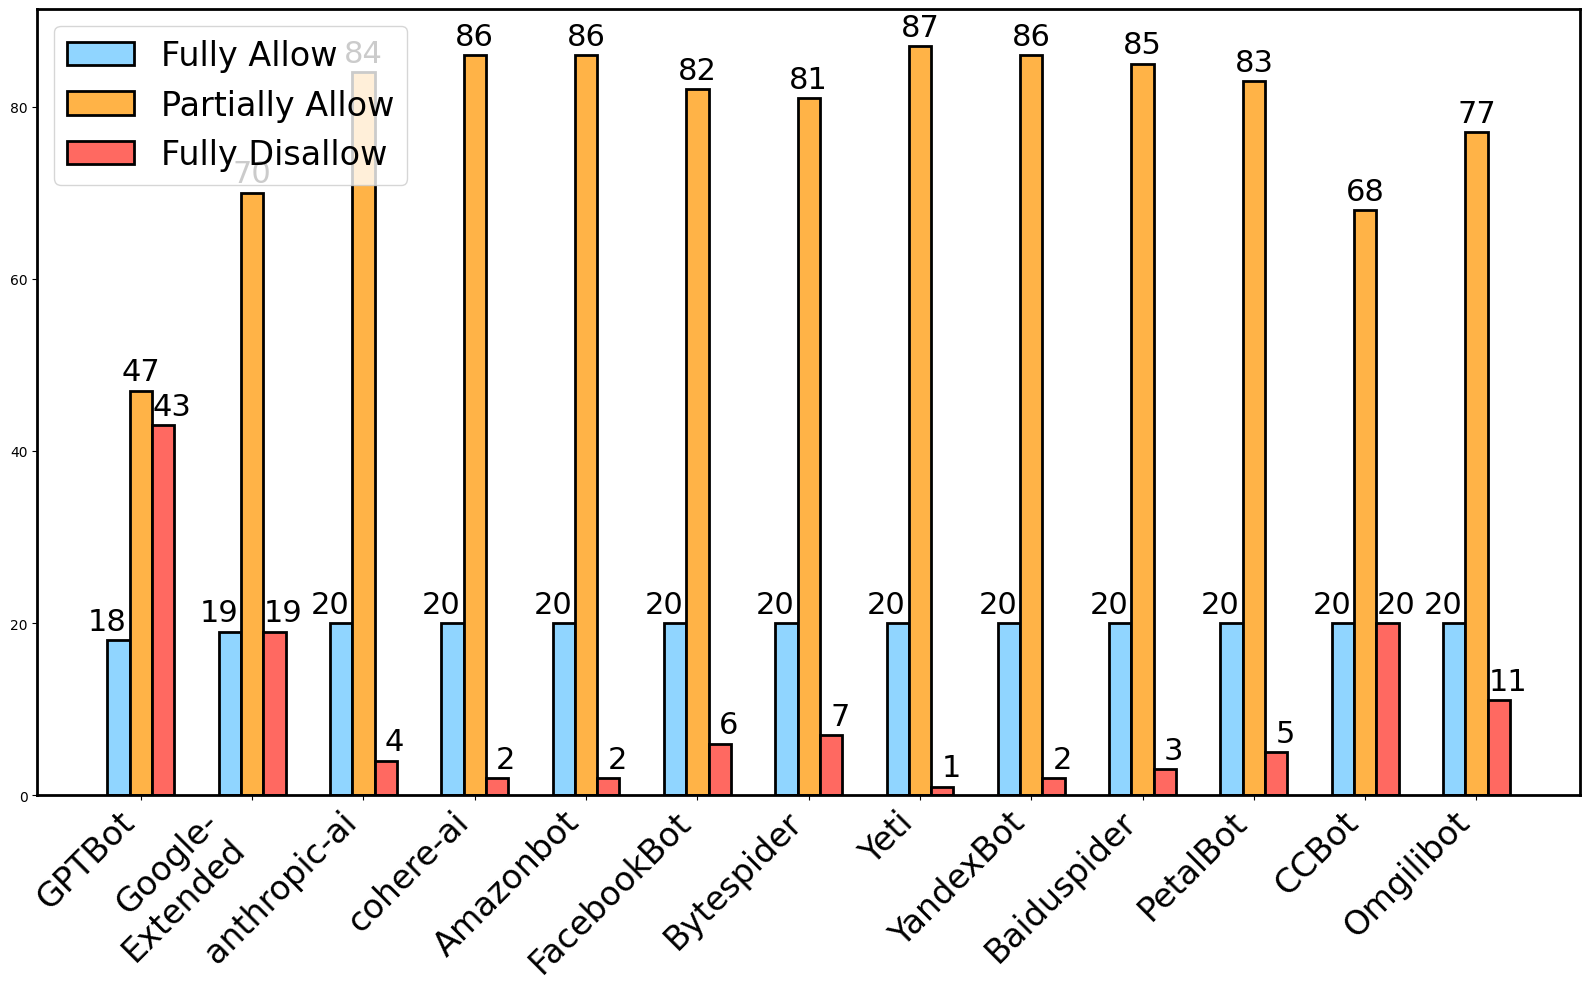

In [7]:
import matplotlib.pyplot as plt

# Plotting with professional adjustments
fig, ax = plt.subplots(figsize=(16, 10))  # Increased figure size for better visibility
index = range(len(bots))
bar_width = 0.2  # Increased from 0.25 to make bars wider

# Specific pastel colors for each category
colors = ['#90d5ff', '#ffb347', '#ff6961']  # pastel blue, pastel orange, pastel red

bar1 = ax.bar(index, allow_all, bar_width, label='Fully Allow', edgecolor='black', color=colors[0], linewidth=2)
bar2 = ax.bar([p + bar_width for p in index], partial, bar_width, label='Partially Allow', edgecolor='black', color=colors[1], linewidth=2)
bar3 = ax.bar([p + bar_width * 2 for p in index], disallow_all, bar_width, label='Fully Disallow', edgecolor='black', color=colors[2], linewidth=2)

ax.set_xticks([p + bar_width for p in index])
ax.set_xticklabels(
    ['GPTBot', 'Google-\nExtended', 'anthropic-ai','cohere-ai',
     "Amazonbot", "FacebookBot", "Bytespider", "Yeti", 
     "YandexBot", "Baiduspider", "PetalBot",
     'CCBot','Omgilibot'], 
    fontsize=24,
    rotation=45,  # Rotates the labels by 45 degrees
    ha='right'    # Aligns the text to the right for better readability
)

# Add a legend
ax.legend(fontsize=24, loc='upper left')

# Make plot box (axes spines) thicker
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Add text annotations for each bar to enhance readability
for i, bars in enumerate([bar1, bar2, bar3]):
    for bar in bars:
        yval = bar.get_height()
        if i == 0:
            ax.text(bar.get_x() + bar.get_width()/2 - 0.1, yval+0.5, int(yval), va='bottom', ha='center', fontsize=22, color='black')
        elif i == 2:
            ax.text(bar.get_x() + bar.get_width()/2 + 0.08, yval+0.5, int(yval), va='bottom', ha='center', fontsize=22, color='black')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval+0.5, int(yval), va='bottom', ha='center', fontsize=22, color='black')

plt.tight_layout()
# plt.tight_layout(rect=[0, 0, 0.95, 1]) 
plt.savefig('plots/policy_robotstxt_mismatch.pdf', format='pdf', dpi=300)
plt.show()

## Fineweb overlap analysis

In [8]:
from collections import defaultdict
from tqdm import tqdm

# Load the saved domain2url dictionary from the JSON file
with open('../measurement_data/fineweb_domain2url.json', 'r') as file:
    fineweb_domain2url = json.load(file)
fineweb_domains = set(list(fineweb_domain2url))

KeyboardInterrupt: 

In [ ]:
overlapped_domain2url = {k: v for k, v in fineweb_domain2url.items() if k in domains} 
sorted_overlapped_domain2url = sorted(overlapped_domain2url.items(), key=lambda item: -len(item[1]))
total_urls = sum(len(v) for v in overlapped_domain2url.values())

print('Number of domains (URLs) that prohibit the use of their content in Fineweb dataset')
print(f"Total number of domains: {len(sorted_overlapped_domain2url):,}")
print(f"Total number of URLs across all domains: {total_urls:,}")

## Table in the artifact 

In [ ]:
print("\nBreakdown by domain:")
for k, v in sorted(overlapped_domain2url.items(), key=lambda item: -len(item[1])):
    print(f"{k}: {len(v)}")